In [1]:
%matplotlib inline
import pykat
import pylab as pl
import pandas
import matplotlib.pyplot as plt
import csv
import math
import numpy as np

pandas.set_eng_float_format(accuracy=3, use_eng_prefix=True)


                                              ..-
    PyKat 1.0.9           _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,  
   `^-....____:   +.      www.gwoptics.org/pykat



In [12]:
katfile = './aLIGO_IFO_AWC_tuning_DCoff_maxtem2.kat'
basekat = pykat.finesse.kat()
basekat.loadKatFile(katfile)
# Don't need these things so removing them
#basekat.removeLine("startnode")
#basekat.removeBlock('locks',True)
#basekat.removeBlock('ASuWFS',True)
#basekat.removeBlock('REFLWFS',True)


# Add QM noise detectors
basekat.parseCommands("""
tf sus 1 0 p $mech_fres $mech_Q
const mech_fres 1  # Approx. resonance frequency
const mech_Q    1M # Guess for suspension Q factor

# Differentially modulate the strain in the arms
fsig darm  LXarm 1 0 1
fsig darm2 LYarm 1 180 1

#fsig darm  ETMXHR 1 0 .5
#fsig darm2 ETMYHR 1 180 .5

sq sqz 0 0 0 nsqz

qnoisedS NSR_with_RP    1 $fs nOMC_AROC_trans
qshotS   NSR_without_RP 1 $fs nOMC_AROC_trans
#qnoised noise    $fs nOMCout
#pd1     signal 1 $fs nOMCout
#pdS3 power $f1 max $f2 max $fs max nOMCout
#pdS sense


xaxis darm f log 5 10k 1000
yaxis log abs
""")

basekat.undumpNodes()
kat=basekat.deepcopy()

out = kat.run()

print(out.x)

hbar=6.62606957E-34/(2.0 *np.pi)
m = 40.
L = 3994.5
SQL_x = np.sqrt( 8 * hbar / ( m * (2*np.pi*out.x)**2)) / L

--------------------------------------------------------------
Running kat - Started at 2016-11-08 14:25:37.016925


 94% | ETA:  0:00:03 | Calculating                                             


Finished in 64.9076 seconds
[  5.00000000e+00   5.03814931e+00   5.07658970e+00 ...,   9.84913159e+03
   9.92427911e+03   1.00000000e+04]


100% | ETA:  0:00:00 | Calculating                                             

In [8]:
gwinc_data = np.genfromtxt('./GwincOutput125W.csv', delimiter=',')
headers = ['Freq','MirrorThermal','Newtonian','Quantum','ResGas','Seismic','SuspThermal','Total']

Freq = []
MirrorThermal = []
Newtonian = []
Quantum = []
ResGas = []
Seismic = []
SuspThermal = []
Total = []
for i in range(len(gwinc_data)):
    Freq.append(gwinc_data[i][0])
    MirrorThermal.append(math.sqrt(gwinc_data[i][1]))
    Newtonian.append(math.sqrt(gwinc_data[i][2]))
    Quantum.append(math.sqrt(gwinc_data[i][3]))
    ResGas.append(math.sqrt(gwinc_data[i][4]))
    Seismic.append(math.sqrt(gwinc_data[i][5]))
    SuspThermal.append(math.sqrt(gwinc_data[i][6]))
    Total.append(math.sqrt(gwinc_data[i][7]))
    

In [9]:
gwinc_data = np.genfromtxt('./GwincOutput125W1.csv', delimiter=',')

Freq1 = []
Quantum1 = []
Total1 = []
for i in range(len(gwinc_data)):
    Freq1.append(gwinc_data[i][0])
    Quantum1.append(gwinc_data[i][1])
    Total1.append(gwinc_data[i][2])
    

In [10]:
###Remember, you have to change the Finesse T_SRM to .2 to get to match up with GWINC.

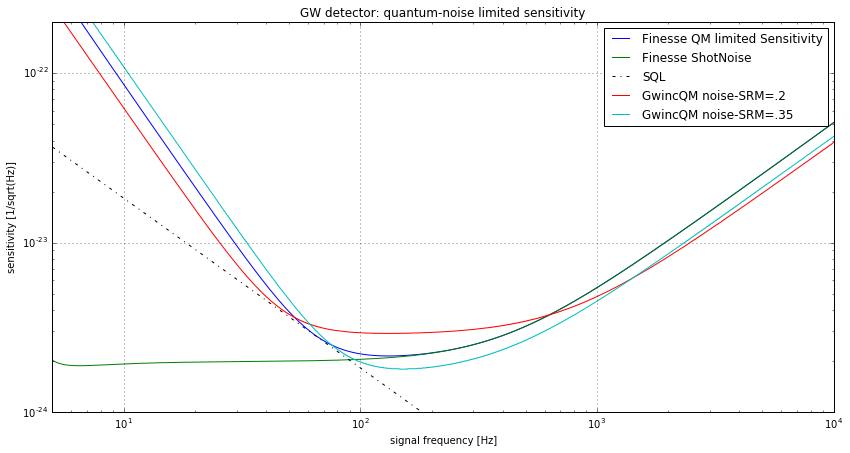

In [13]:
plt.figure(figsize=(14,7))
plt.loglog(out.x,out['NSR_with_RP'], label='Finesse QM limited Sensitivity')
plt.loglog(out.x,out['NSR_without_RP'],label='Finesse ShotNoise')
plt.loglog(out.x,SQL_x,'-.',color='k', label='SQL')
plt.loglog(Freq,Quantum,label='GwincQM noise-SRM=.2')
#plt.loglog(Freq,Total,label='Gwinc total noise-SRM=.2')
plt.loglog(Freq1,Quantum1,label='GwincQM noise-SRM=.35')
#plt.loglog(Freq1,Total1,label='Gwinc total noise-SRM=.35')
plt.title('GW detector: quantum-noise limited sensitivity')
plt.xlabel('signal frequency [Hz]')
plt.xlim([min(out.x),max(out.x)])
plt.ylim([1E-24,2E-22])
plt.legend()
plt.ylabel('sensitivity [1/sqrt(Hz)]')
plt.grid(True)
